#**Homework 2 : Gaussian Mixture Model (GMM)**
Author : **raphael** ING5 Promo 

##1. Initialize θ=(Φ, µ, Σ) and samples

In [3]:
import numpy as np

n_samples = 300
N = 3 #Dimension
J = 2 #Number of clusters / gaussians

#coordinates of the center of the gaussians / mean
µ = np.array([[0,3],
              [0,3],
              [0,3]]) #NxJ

#Covariance_matrix.shape = (J,N,N) ==> Covariance_matrix[J][N][N]
Covariance_matrix = np.array([ [[.7, 0, 0], 
                                [0, .7, 0], 
                                [0, 0, .7]],

                              [[1, 0, 0], 
                               [0, 1, 0],
                               [0, 0, 1]]] ) 
Phi = [1/2 for j in range(J)]

# generate random sample, two components
np.random.seed(0)

# generate zero centered stretched Gaussian data
stretched_gaussian = np.dot(np.random.randn(n_samples, N), Covariance_matrix[0,:,:]) + µ[:,0]

# generate spherical data centered on (20, 20)
shifted_gaussian = np.dot(np.random.randn(n_samples, N), Covariance_matrix[1,:,:]) + µ[:,1]

# concatenate the two datasets into the final training set
X_train = np.vstack([  shifted_gaussian, stretched_gaussian ])

print(stretched_gaussian.shape)
print(shifted_gaussian.shape)
print(Covariance_matrix.shape)
print(µ.shape)

(300, 3)
(300, 3)
(2, 3, 3)
(3, 2)


##2. Expectation-Maximization (EM) algorithm

###2.1 Expectection step
Let's write the function **E_step(Φ, µ, Σ)** that returns an array IxJ of :

<center>

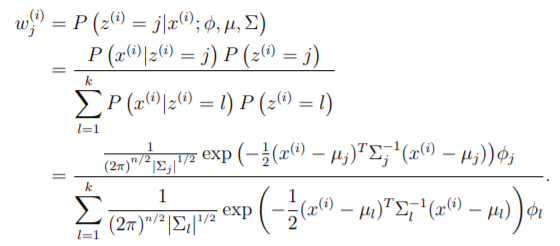

</center>



In [4]:

import math as m

I = len(X_train)#Total number of samples


def E_step(phi, mu, covariance):
#
#param : phi, a list containing each phi_j of the gaussian
#        mu, an array NxJ containing each mean of the gaussian
#        covariance, an array JxNxN containing each covariance_j of the gaussian
#return: compute Wj(i), also called Qi(z(i)=j), for all i and j
#        return an array IxJ
# 
    Wj = np.zeros((I,2))
    for i in range(I):
        for j in range(J):
            Sum = 0 #initialize the sum of all the j for P(X(i)|Z(i)=j; theta) 

            for k in range(J):
                A = ( X_train[i]-mu[:,k]) #already an array 1xN
                B = A.dot( np.linalg.inv(covariance[k,:,:]) ) # product of matrix A and Covariance_matrix[k,:,:]^-1
                C = (X_train[i]-mu[:,k]).reshape(N,1)
                Sum += np.exp(-0.5 * B.dot(C)) * phi[k] / ( (2*m.pi)**(N/2) * m.sqrt(abs(np.linalg.det(covariance[k,:,:]))) )
           
            A = (X_train[i]-mu[:,j]) #already an array 1xN 
            B = A.dot( np.linalg.inv(covariance[j,:,:]) ) # product of matrix A and Covariance_matrix[j,:,:]^-1
            C = (X_train[i]-mu[:,j]).reshape(N,1)
            Wj[i][j] = (np.exp(-0.5*B.dot(C))*phi[j] / ( (2*m.pi)**(N/2) * m.sqrt(abs(np.linalg.det(covariance[j,:,:])))) ) /Sum
            
    return Wj

###2.2 Maximization step

Now let's write the function **Max_step(Wj)** that computes θ = (Φ, µ, Σ)

<center>

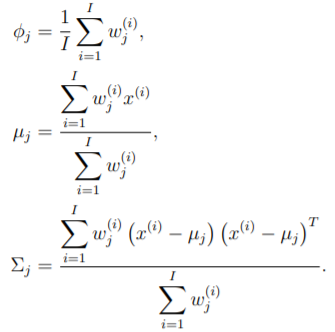

</center>

In [5]:

def Max_step(Wj):
#
#param : Wj computed in E_step function
#return: phi, a list containing each phi_j of the gaussian
#        mu, an array NxJ containing each mean of the gaussian
#        covariance, an array JxNxN containing each covariance_j of the gaussian

    #Initialization
    mu = np.zeros((N,J))
    covariance = np.zeros((J,N,N))
    phi = []
    Sum_Wj = np.sum(Wj, axis=0) #Sum all the lines for each column of Wj 
    if (Sum_Wj[0] == 0 or Sum_Wj[1] ==0):
        print("ALERT ! ZERO VALUE IN Wj !")
  
    for j in range(J):
        phi.append(Sum_Wj[j]/I)   #phi_j computed and add to the list
        Sum_mu = np.zeros((1,N))  #Initialize value of the numerator in µj
        Sum_covar = np.zeros((N,N)) #Initialize value of the numerator in sigma_j
        
        #Start computing µj
        for i in range(I):
            #compute the sum on the numerator of µj
            Sum_mu += Wj[i][j]*X_train[i] 
        Sum_mu = Sum_mu/Sum_Wj[j] #Compute µj
        mu[:,j] = Sum_mu #add µj in µ
        
        #Start computing Sigma_j (corvariance_j)
        for i in range(I):
            #compute the sum on the numerator of sigma_j
            A = (X_train[i]-mu[:,j]).reshape(N,1)
            B = (X_train[i]-mu[:,j]).reshape(1,N) 
            Sum_covar += Wj[i][j]* (A.dot(B))
        Sum_covar = Sum_covar/Sum_Wj[j] #Compute Sigma_j
        covariance[j,:,:] = Sum_covar # add Sigma_j in covariance
  
    return (phi, mu, covariance)

###2.3 EM algorithm

The purpose of the EM algorithm is to find the optimazed θ* = (Φ, µ, Σ) such as the gradient of *ll*(θ) is equal to zero

<center>

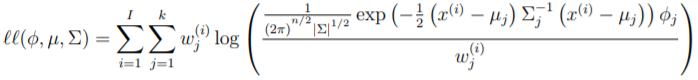

</center>

In [6]:

def EM(phi, mu, covariance):
  error = 1e-5
  E_new = 1

  iter = 0
  ll_theta_old = 0
  while (E_new >= error):
      #update wj, phi, mu, covariance 
      wj = E_step(phi, mu, covariance)
      phi, mu, covariance = Max_step(wj)
    
      #start counting number of iterations
      Sum_outer = 0 #1st sum symbol for all i in ll(theta)
      for i in range(I):
          Sum_inner = 0  #2nd sum symbol for all j in ll(theta)
          for j in range(J):
              A = (X_train[i]-mu[:,j]).reshape(1,N)
              B = A.dot( np.linalg.inv(covariance[j,:,:]) )
              C = (X_train[i]-mu[:,j]).reshape(N,1)
              D = B.dot(C)
              numerator = np.exp(-0.5*D)*phi[j] / ( (2*m.pi)**(N/2) * np.sqrt(abs(np.linalg.det(covariance[j,:,:]))))

              if (wj[i][j]!=0):
                  Sum_inner += wj[i][j] * (np.log(numerator)-np.log(wj[i][j]))
          Sum_outer += Sum_inner
      ll_theta_new = Sum_outer
      E_new = abs(ll_theta_new - ll_theta_old)
      ll_theta_old = ll_theta_new
      iter += 1

    #print("iter :", iter)

  print("Nb of iteration :", iter)
  print("Covariance :\n",covariance)
  print("µ :\n",mu)
  print("Phi :\n",phi)

  return (phi, mu, covariance)

(Phi, µ, Covariance_matrix) = EM(Phi, µ, Covariance_matrix)

Nb of iteration : 6
Covariance :
 [[[ 0.49398363 -0.04102864  0.01884058]
  [-0.04102864  0.50381957 -0.03062716]
  [ 0.01884058 -0.03062716  0.42810201]]

 [[ 0.88667174  0.03429706 -0.05560697]
  [ 0.03429706  1.0764461  -0.04804571]
  [-0.05560697 -0.04804571  0.90046395]]]
µ :
 [[-1.59920675e-03  3.02515320e+00]
 [-5.64961196e-02  3.02218789e+00]
 [-9.47605141e-02  3.06147104e+00]]
Phi :
 [0.4987867420686294, 0.5012132579313711]


Once θ* = (Φ, µ, Σ) has been found (very similar to those defined at the beginning), we need to compute the equation below in a variable for each sample. It will classifies which cluster a point belongs to

<center>

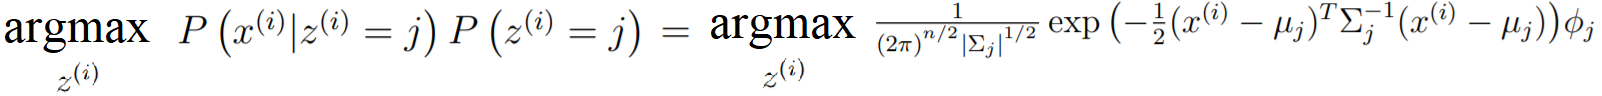
</center>

In [7]:
def classify(phi, mu, covariance):
  y = np.zeros((I,J)) 

  for i in range(I):
    for j in range(J):
      A = (X_train[i]-mu[:,j]) #already an array 1xN 
      B = A.dot( np.linalg.inv(covariance[j,:,:]) ) # product of matrix A and covariance[j,:,:]^-1
      C = (X_train[i]-mu[:,j]).reshape(N,1)
      
      y[i][j] = np.exp(-0.5*B.dot(C))*Phi[j] / ( (2*m.pi)**(N/2) * m.sqrt(np.linalg.det(covariance[j,:,:])))

#Return the max value of each line i  between zi(j=0) and zi(j=1)
  y = np.argmax(y, axis=1)
  return y

y = classify(Phi, µ, Covariance_matrix)

print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [8]:
np.sum(y)#300 points out of 600

300

##3. Plot

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_plot(Y):

  fig1=plt.figure()
  ax=Axes3D(fig1)
  for i in range(I):
      if (Y[i]==0):
          ax.scatter(X_train[i, 0], X_train[i, 1],  X_train[i, 2], color='red')
      else:
          ax.scatter(X_train[i, 0], X_train[i, 1],  X_train[i, 2], color='blue')
  #ax.view_init(90)
  plt.show()

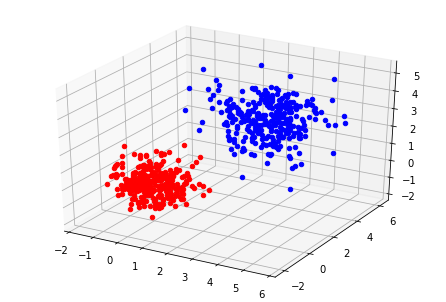

In [10]:
show_plot(y)

We can see that 100% of our points have been well classified. That's because the two gaussians are far enough from each other so that they don't overlap

Now let's look at two closed gaussians (we only change µ)

Nb of iteration : 115
Covariance :
 [[[ 0.4298702  -0.07455076 -0.00824232]
  [-0.07455076  0.47513528 -0.05733994]
  [-0.00824232 -0.05733994  0.34513457]]

 [[ 0.91039874  0.15096194 -0.05176058]
  [ 0.15096194  1.15593102 -0.01311498]
  [-0.05176058 -0.01311498  0.80657281]]]
µ :
 [[-0.082521    0.89878301]
 [-0.05669137  0.83485047]
 [-0.24138384  0.54397484]]
Phi :
 [0.3906371286361788, 0.6093628713638215]
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1

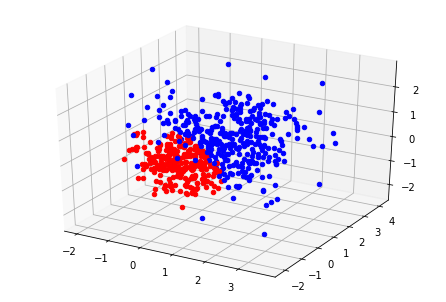

In [11]:
µ = np.array([[0,1],
              [0,1],
              [0,.5]]) #NxJ


#Covariance_matrix.shape = (J,N,N) ==> Covariance_matrix[J][N][N]
Covariance_matrix = np.array([ [[.7, 0, 0], 
                                [0, .7, 0], 
                                [0, 0, .7]],

                              [[1, 0, 0], 
                               [0, 1, 0],
                               [0, 0, 1]]] ) 
Phi = [1/2 for j in range(J)]
# generate random sample, two components
np.random.seed(0)

# generate zero centered stretched Gaussian data
stretched_gaussian = np.dot(np.random.randn(n_samples, N), Covariance_matrix[0,:,:]) + µ[:,0]

# generate spherical data centered on (20, 20)
shifted_gaussian = np.dot(np.random.randn(n_samples, N), Covariance_matrix[1,:,:]) + µ[:,1]

# concatenate the two datasets into the final training set
X_train = np.vstack([  shifted_gaussian, stretched_gaussian ])

(Phi, µ, Covariance_matrix) = EM(Phi, µ, Covariance_matrix)
y = classify(Phi, µ, Covariance_matrix)
print(y)

show_plot(y)

In [12]:
np.sum(y)#334 blue points instead of 300

344

This time, it takes longer to run the programm and it's harder to classify some points